## Code for Sparcle: spot reassignments in transcriptomic images

## Github's Sparcle_parallel.py is from Lilac's 400 FoV run. 
## Modified this code to handle wtg mockcell and Given's rotation. This version gets uploaded to Github as Sparcle_parallel_wtgmc_gr.py
## Modified this code to print FoV intermediate. #nx31. This version gets uploaded to Github as Sparcle_parallel_intermediatePrinting_FoV.py

In [271]:
import os
import sys

import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import time

from matplotlib.patches import Polygon

from PIL import Image, ImageDraw
from skimage import measure #package is scikit-image

import pandas as pd


import matplotlib.pyplot as plt
plt.close('all')

from scipy.spatial import distance

import phenograph as pg
import cv2

from sklearn.mixture import BayesianGaussianMixture
from sklearn.manifold import TSNE

#import matplotlib
#matplotlib.use('Agg')

import random
from scipy.stats import zscore

import scipy.stats as stats
from scipy.stats import multivariate_normal

from joblib import Parallel, delayed
import multiprocessing

import scipy.io
from scipy.io import mmread

import colorsys

import seaborn as sns
import fastcluster


from scipy.spatial import distance

from numpy.lib.stride_tricks import as_strided

import tifffile


In [272]:
############
#### define path variables for data, Python code, R code etc
############


path_data = '/Users/sandhyaprabhakaran/Downloads/Jeff_MERFISH_data' #'/Users/sandhyaprabhakaran/Downloads/Jeff_MERFISH_data'
path_t = os.getcwd() #'/Users/prabhaks/Desktop/Python_R_codebase'
path_t = '/Users/sandhyaprabhakaran/Downloads/Jeff_MERFISH_data/amme_narayana'
path_python = path_t #os.path.join(path_t+"/MIBI_model"); just in case you have code and data in same file level, then use uncomment
#path_R = os.path.join(path_t+ "/superpixel_MIBI_python")
path_scseq = os.path.join(path_data + '/GSE113576_matrix.mtx')
path_cb = os.path.join(path_data + '/M22E1_codebook.csv')
path_temp_2 = os.path.join(path_data + '/GSE113576_genes.tsv')

path_Allen = os.path.join(path_data+'/SongLinROIS_deduplicated.json')
brian_csv_path = os.path.join(path_data+'/smFISH_MCT_CZI_Panel_0_spot_table.csv')

#read in the cluster ids
path_sc_cellid = os.path.join(path_data + '/aau5324_Moffitt_Table-S1.xlsx')

#read in Allen data .csvs
path_Allen_data = '/home/prabhaks/Merfish_model/Merfish/Jeff_MERFISH_data/Allen_data'

fov_count = 'current_run/'

In [273]:



"""Module for Givens rotation."""

from math import copysign, hypot

import numpy as np





def givens_rotation(A):
    """Perform QR decomposition of matrix A using Givens rotation."""
    (num_rows, num_cols) = np.shape(A)

    # Initialize orthogonal matrix Q and upper triangular matrix R.
    Q = np.identity(num_rows)
    R = np.copy(A)

    # Iterate over lower triangular matrix.
    (rows, cols) = np.tril_indices(num_rows, -1, num_cols)
    for (row, col) in zip(rows, cols):

        # Compute Givens rotation matrix and
        # zero-out lower triangular matrix entries.
        if R[row, col] != 0:
            (c, s) = _givens_rotation_matrix_entries(R[col, col], R[row, col])

            G = np.identity(num_rows)
            G[[col, row], [col, row]] = c
            G[row, col] = s
            G[col, row] = -s

            R = np.dot(G, R)
            Q = np.dot(Q, G.T)

    return (Q, R)


def _givens_rotation_matrix_entries(a, b):
    """Compute matrix entries for Givens rotation."""
    r = hypot(a, b)
    c = a/r
    s = -b/r

    return (c, s)


In [274]:


def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-',linewidth=0.5)


colours=[ "darkviolet", "red", "orange", "limegreen", "blue", "purple", "seagreen","gold","lightpink","thistle","mistyrose","saddlebrown","slategrey",
            "palevioletred","mediumvioletred","yellowgreen","darkolivegreen","lemonchiffon","chocolate","lightsalmon","lightcyan","lightblue", "black"]

# perspective projection of stage coord to image coord


pts_src = np.array([[-3357.4,-4078.2], [-3357.4,-3855.3], [-3134.5,-4078.2], [-3134.5,-3855.3]])
# corresponding points from image 2 (i.e. (154, 174) matches (212, 80))
pts_dst = np.array([[0.0,0.0], [0.0,2048.0], [2048.0,0.0],[2048.0,2048.0]])

#pts_src = np.array([[-3357.4,-4078.2], [-3357.4,-3855.3], [-3134.5,-4078.2], [-3134.5,-3855.3]])
# corresponding points from image 2 (i.e. (154, 174) matches (212, 80))
#pts_dst = np.array([[0.0,0.0], [0.0,2048.0], [2048.0,0.0],[2048.0,2048.0]])

# calculate matrix H
h, status = cv2.findHomography(pts_src, pts_dst)

def setdiff2d(lst1,lst2):
    aset = set([tuple(x) for x in lst1])
    bset = set([tuple(x) for x in lst2])
    l = np.array([x for x in aset - bset])
    return l

def is_nan(x):
    return (x is np.nan or x != x)


def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        r_c = np.random.rand()
        hue = i/360.
        lightness = (50 + r_c * 10)/100.
        saturation = (90 + r_c * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

#set clustering algorithm choice
bayes_MM = 0 # to run the DPMM else set to 0 for phenograph

num_comp = 10

neigh_size = 15

dist_ub = 150

#dist_threshold = 100

dpi_set = 100

num_pg_k = 50

num_fov = 2

#sc_norm = 'zscore' # or 'log'
#random.seed(9001)

mRNA_asgn_counter = np.zeros([num_fov,1])

s_size = 20

#num_colour = 50
win_size = 150
#cm = plt.cm.get_cmap('tab20',num_colour)
#cm = get_colors(num_colour)
cm = colours

f_size=10

fig2p = 0

z = 2

num_cell_fov = np.zeros(num_fov, dtype=int)

asgn_stats_list=[] #added sandhya
asgn_stats_listoflists = [] #added sandhya

mRNA_assign_listoflists = [] # 1st July 2020
iterations = 2
num_cores = multiprocessing.cpu_count() - 1
inputs = range(num_fov)

Merfish_genes = 140

givens = False
wgt_mock_cell = False

/Users/sandhyaprabhakaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Time taken to execute FOV consolidation: 9.51034688949585 secs
Time taken to execute FOV consolidation: 0.1585057814915975 mins
total mRNA across all FOVs: 63941
total dangling mRNA across all FOVs: 33459
Number of cells in Fov 0 is:79
Number of cells in Fov 1 is:73
rows_remove
(array([], dtype=int64), array([], dtype=int64))
cell_cumsum b4
[  0  79 152]
cell_cumsum after
[  0  79 152]
(152, 140)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 152 samples in 0.000s...
[t-SNE] Computed neighbors for 152 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 152 / 152
[t-SNE] Mean sigma: 5.974906
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.448795
[t-SNE] KL divergence after 1000 iterations: 0.199147
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.10793495178222656 seconds
Jaccard graph constructed in 0.09025692939758301 seconds
Wrote graph to binary file in 0.025124788284301758 secon

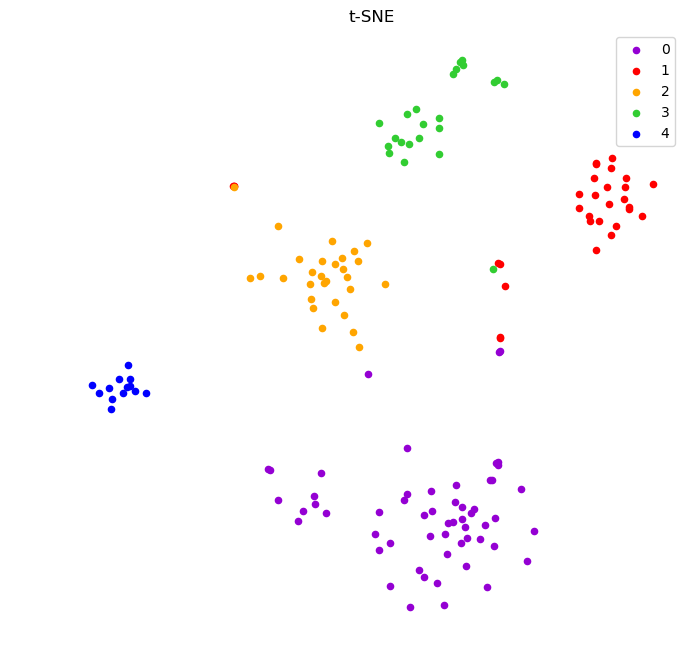

0
1
2
3
4


<Figure size 432x288 with 0 Axes>

In [275]:
## Merfish assignment code
## Code author SP
##
##
## 5th Feb 2019 - clustering methods
## 6th Feb 2019 - cluster moments extraction
## 9th Feb 2019 - normality tests check, find nearest cells to an mRNA
## 10th Feb 2019 - adding Gaussian copula to work with marginals
## 10th Mar 2019 - loop added to take in multiple FOVs
## 20th Mar 2019 - tidying up plots
## 11th July 2019 - parallelising the loops
## does not use the scRNA seq cluster moments 
##
## bug in the parallelisation code for iteration >=1
##
##June - July 2020 - redoing the code with edits, adding Merfish start, distance ub, ##
## July 31st 2020 - only printing the assignments in FOVs in loop Overall




############
#### Main code
############
t1 = time.time()

path_temp = os.path.join(path_data + '/barcode_metadata.csv')
mRNA_metadata_t = np.array(pd.read_csv(path_temp).as_matrix())

Merfish_CM_list = []
mRNA_assign_list = []
closest_cells_list = []
mRNA_coords_list = []
CoM_image_coords_list =[]
cell_metadata_t_list = []
mRNA_all_list = []

num_cell_fov = np.zeros(num_fov, dtype=int) 

###########################################
######## Build the mRNA stats per FOV #####
###########################################

inputs = range(num_fov) 

def processFOV(f):
    print('Fov is: ', str(f))
    
    if (f < 10):
        f_name = str("/cell_metadata/cell_metadata_fov_00"+str(f)+".csv")
    elif (f <= 99):
        f_name = str("/cell_metadata/cell_metadata_fov_0"+str(f)+".csv")
    else:
        f_name = str("/cell_metadata/cell_metadata_fov_"+str(f)+".csv")
    
    mRNA_all = np.where(mRNA_metadata_t[:,1] == f) 
    mRNA_all = np.array(mRNA_all).flatten()
    print("number of mRNA rows in Fov ",str(f),"= ", mRNA_all.shape)
    #return [mRNA_all_list.append(mRNA_all)]
    
    #read in mRNA needed for clustering
    #mRNA_certain = np.where((mRNA_metadata_t[:,1] == f) & (mRNA_metadata_t[:,10] ==1))# & (mRNA_metadata_t[:,5] ==1.5)) #fov_id = 0 and in_feature = 1 and z-plane = 2
    #mRNA_certain = np.array(mRNA_certain).flatten()
    #print("number of mRNA rows in Fov ",str(f)," for clustering = ", mRNA_certain.shape)

    #print("number of unique genes or barcodes in Fov ",str(f),"(for clustering) = ", np.unique(mRNA_metadata_t[mRNA_certain,0]).shape)
    
    
    #read in mRNA needed for reassignment
    mRNA_assign = np.where((mRNA_metadata_t[:,1] == f) & (mRNA_metadata_t[:,10] ==0))# & (mRNA_metadata_t[:,5] ==1.5)) #fov_id = 0 and in_feature = 0 and z-plane = 2
    mRNA_assign = np.array(mRNA_assign).flatten()
    print("number of mRNA rows in Fov ",str(f)," for reassignment = ", mRNA_assign.shape)

    print("number of unique genes or barcodes in Fov ",str(f)," (for reassignment) = ", np.unique(mRNA_metadata_t[mRNA_assign,0]).shape)
    #mRNA_assign_list.append(mRNA_assign)

    # Build the count matrix of cells x genes per FOV
    
    path_temp = os.path.join(path_data + f_name)
    
    cell_metadata_t = np.array(pd.read_csv(path_temp).as_matrix()) #.astype("float")
    #cell_metadata_t_list.append(cell_metadata_t)
    
    num_cells = cell_metadata_t.shape[0]
    num_genes = np.unique(mRNA_metadata_t[mRNA_all,0]).shape[0]

    Merfish_CM = np.zeros([num_cells, num_genes], dtype=float) #this has to be a matrix with ALL the genes 
    
    
    for i in range(num_cells):
        feat_id = cell_metadata_t[i,1]
        #print("cell is", feat_id)
        CM_row = np.where(cell_metadata_t[:,1]==feat_id)
        #print("cell row is", CM_row)
        #for 'f' fov, all the spots that are to be considered for clustering and for a given cell (feat_id)
        feat_rows = np.where((mRNA_metadata_t[:,1]==f) & (mRNA_metadata_t[:,9]==feat_id) & (mRNA_metadata_t[:,10]==1))# & (mRNA_metadata_t[:,5] == 1.5)) #fov id, which cell and in/out of cell
        #feat_rows = np.where((mRNA_metadata_t[:, 1] == 0) & (mRNA_metadata_t[:, 9] == feat_id))
        feat_rows = np.array(feat_rows).flatten()
        num_rows = feat_rows.shape[0]


        for j in range(num_rows):
            bc_id = mRNA_metadata_t[feat_rows[j],0]-1 #telling which gene it is and where the entry should go to in the count matrix
            #print("gene is", bc_id)
            #Merfish_CM[CM_row,int(bc_id)] = Merfish_CM[CM_row,int(bc_id)]  +  mRNA_metadata_t[feat_rows[j],2]/mRNA_metadata_t[feat_rows[j],6] #area normalised values

            #intensity-based count matrix
            #Merfish_CM[CM_row,int(bc_id)] = Merfish_CM[CM_row,int(bc_id)]  +  mRNA_metadata_t[feat_rows[j],2]

            #count matrix
            Merfish_CM[CM_row,int(bc_id)] = Merfish_CM[CM_row,int(bc_id)]  +  1

    #Merfish_CM_list.append(Merfish_CM)
    
    return f_name, mRNA_all, mRNA_assign, cell_metadata_t, num_cells, num_genes, Merfish_CM
#num_cores = multiprocessing.cpu_count()
     
t1 = time.time()

results = Parallel(n_jobs=num_cores)(delayed(processFOV)(f) for f in inputs)

t2 = time.time()
print('Time taken to execute FOV consolidation:', str(t2-t1),'secs')
print('Time taken to execute FOV consolidation:', str((t2-t1)/60),'mins')

#collect the results

ff_name=[item[0] for item in results]
mRNA_all_list=[item[1] for item in results]
mRNA_assign_list=[item[2] for item in results]
cell_metadata_t_list=[item[3] for item in results]
num_cells_list=[item[4] for item in results]
num_genes_list=[item[5] for item in results]
Merfish_CM_list=[item[6] for item in results]

## added 20th June 2020
total_mRNA = 0
total_dang_mRNA = 0
for kl in range(num_fov):
    total_mRNA = total_mRNA + mRNA_all_list[kl].shape[0]
    total_dang_mRNA = total_dang_mRNA + mRNA_assign_list[kl].shape[0]
print('total mRNA across all FOVs:', str(total_mRNA))
print('total dangling mRNA across all FOVs:',str(total_dang_mRNA))
###

cell_cumsum = np.cumsum(num_cells_list)
cell_cumsum = np.hstack((0,cell_cumsum))

#1st July 2020
Merfish_CM = np.zeros((1,Merfish_genes)) #will have all the Count matrices consolidated
#Merfish_CM = np.zeros((1,num_genes_list[0])) #will have all the Count matrices consolidated

for f in range(num_fov):
    print("Number of cells in Fov "+str(f)+" is:"+str(Merfish_CM_list[f].shape[0]))
    Merfish_CM = np.concatenate((Merfish_CM,Merfish_CM_list[f]),axis=0)
   
    
Merfish_CM = np.delete(Merfish_CM, (0), axis=0)

#remove rows that have 0 rowsum

row_sums_CM = Merfish_CM.sum(axis=1,keepdims=True)
rows_remove = np.where(row_sums_CM==0)
Merfish_CM = np.delete(Merfish_CM,(rows_remove),axis=0)

#### added 20th June 2020
print("rows_remove")
print(rows_remove)
print('cell_cumsum b4')
print(cell_cumsum)
#adjust for cells removed per bin so that cumsum reflects the correct number of cells per FOV
for i in range(len(rows_remove[0])):
    print('i is', str(i))
    for j in range(i+1):
        print('j is', str(j))
        if ((j+1) < (len(cell_cumsum))):
            if (rows_remove[0][i] < cell_cumsum[j+1]):
                cell_cumsum[j+1] = cell_cumsum[j+1] - 1
                print(cell_cumsum)
        continue
    continue

print('cell_cumsum after')
print(cell_cumsum)
##################
M = zscore(Merfish_CM,axis=1)

M_upd = M

num_cells = M.shape[0]
num_genes = Merfish_genes #M.shape[1]

print(M.shape) # added 20th June 2020

df_data = pd.DataFrame(Merfish_CM)
df_data.to_csv(os.path.join(path_python + '/count_data/count_matrix_JeffMerfish_fovall.csv'), header=None, index=None)


df_data = pd.DataFrame(M)
df_data.to_csv(os.path.join(path_python + '/count_data/count_matrix_M_fovall.csv'), header=None, index=None)


tsne = TSNE(n_components=2, verbose=1)#, perplexity=30, n_iter=900)
X_2d = tsne.fit_transform(M)

if(bayes_MM):
    Mod_dpgmm=BayesianGaussianMixture(n_components=num_comp, covariance_type='full',weight_concentration_prior_type='dirichlet_process').fit(M)
    cluster_asgn = Mod_dpgmm.predict(M)
else:
    communities, graph, Q = pg.cluster(M)#, k=num_comp, min_cluster_size=1)
    cluster_asgn = communities

df_clusterlabel = pd.DataFrame(cluster_asgn)
df_clusterlabel.to_csv(os.path.join(path_python + '/count_data/cluster_labels_b4.csv'), header=None,
                   index=None)

unique, counts = np.unique(cluster_asgn, return_counts=True)

#t-SNE plots
target_ids = range(len(unique))
plt.figure(figsize=(8,8),frameon=False,dpi=dpi_set)
plt.axis('off')
#colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i,  label in zip(target_ids,  unique):
    plt.scatter(X_2d[ cluster_asgn==(i), 0], X_2d[ cluster_asgn==(i), 1],  color=cm[i], label=label,s=s_size)
plt.legend()
plt.title('t-SNE')
plt.show()
file_name = os.path.join(path_python+'/figures_python/tSNE_labels.png')
plt.savefig(file_name,dpi=dpi_set)

df_data = pd.DataFrame(X_2d)
df_data.to_csv(os.path.join(path_python + '/count_data/tSNE_embedding_pre.csv'), header=None, index=None)

###############################
## construct the cluster moments
###############################

mean_mat = [] #1 x genes per entry. K x genes overall
cov_list = [] # genes x genes per entry. K genes x genes overall
joint_mat = [] # samples X genes per entry. K samples x genes overall
U_mat = [] # samples X genes per entry. K samples x genes overall
num_genes = Merfish_genes ## remove on Lilac


for i in range(len(unique)): #target_ids:
    print(i)
    rows = np.where(cluster_asgn==unique[i])
    rows = np.array(rows).flatten()


    if (rows.shape[0] > 1):
        mean_mat.append(np.mean(M[rows, :], axis=0)) # added 3rd july 
        #cov_list.append(np.cov(M[rows, 0:num_genes].T))
        #joint_mat.append(np.random.multivariate_normal(mean_mat[i][0:num_genes], cov_list[i], num_unif_samples))
        #####joint_mat.append(multivariate_normal.logpdf(mean_mat[i][0:10], cov_list[i], num_unif_samples))
        cov_mat = np.cov(M[rows, 0:num_genes].T)
        cov_mat = np.dot(cov_mat,cov_mat.T)
        np.fill_diagonal(cov_mat, np.diag(cov_mat)+0.01)
        if (givens):
            (Q, R) = givens_rotation(cov_mat)
            cov_list.append(R)  
        else:
            cov_list.append(cov_mat)
         




In [276]:
len(mRNA_assign_list[0])

13399

In [277]:
################################
## Iteration 0 #################
################################


#inputs = range(num_fov) 
def processIter0(f):
    
    #mRNA_asgn_counter = np.zeros([num_fov,1]) #added 1st July 2020
    asgn_stats = np.array([0,0,0,0]) #added sandhya, iter, fov, p, cellitwentto

    print('Fov is: ', str(f))

    num_cells = cell_metadata_t_list[f].shape[0]

    #perspective projection
    if z==1:
        z_x = 6
        z_y = 7
    else:
        z_x = 6 + 2**(z-1)
        z_y = 7 + 2**(z-1)

    rw_x_boundary = cell_metadata_t_list[f][:,z_x]
    rw_y_boundary = cell_metadata_t_list[f][:,z_y]

    CoM_stage_coords = np.zeros([num_cells, 2], dtype=np.float)
    CoM_image_coords = np.zeros([num_cells, 2], dtype=np.float)

    #fig1 = (f+1)*100+(f+1)
    
    '''nx31
    '''
    if(fig2p==1):
        fig2 = (f+1)*200+(f+1)
    fig4 = (f+1)*400+(f+1)

    plt.figure(fig4,dpi=dpi_set,figsize=(12,12))
    plt.title(str(f))
    plt.axis('off')
    '''
    '''
    
    
    print('plotting cells')
    for i in range(num_cells): #i will be i+2th row in the xls

        #print("Cell= " + str(i))

        if(is_nan(rw_x_boundary[i]) | is_nan(rw_y_boundary[i])): #entries were empty: no segmentation found
            print("skip cell ", str(i))
        else:
            m = rw_x_boundary[i].split(';')
            n = rw_y_boundary[i].split(';')
            num_coord = m.__len__()

            # this can be done smarter. for now I cast every string float to float and place into a list
            m_list = []
            n_list = []
            for j in range(num_coord-1):
                if( (float(m[j])!=float(m[j]))  or (float(n[j])!=float(n[j]))):
                    print("Coord NaN is at = " + str(j))
                    #continue
                else:
                    m_list.append(float(m[j]))
                    n_list.append(float(n[j]))

            #to plot the stage coords
            #for k in np.arange(0, m_list.__len__()-1, 2):
                #print(k)
                #plt.figure(fig1,figsize=(10,10),dpi=dpi_set)
            #    connectpoints(m_list, n_list, k, k + 1)

            x_coord = np.array(m_list)  # (256,)
            y_coord = np.array(n_list)  # (256,)
            f1 = np.vstack((x_coord, y_coord))  # (2, 256)

            cX = sum(f1[0, :]) / f1.shape[1]
            cY = sum(f1[1, :]) / f1.shape[1]

            '''nx31
            '''
            CoM_stage_coords[i, 0] = cX
            CoM_stage_coords[i, 1] = cY
            '''
            '''
            
            #plt.figure(fig1,dpi=dpi_set,figsize=(10,10))
            #axes = plt.gca()
            #axes.add_patch(Polygon(np.transpose(f1),closed=True, facecolor=colours[cluster_asgn[i]]))
            #plt.axis('off')


            #to project to the image coords

            im_list = []
            in_list = []
            for s in range(m_list.__len__()):
                a = np.array([[f1[0, s], f1[1, s]]], dtype='float32')
                a = np.array([a])
                pointsOut = cv2.perspectiveTransform(a, h)
                im_list.append(pointsOut[0,0,0])
                in_list.append(pointsOut[0,0,1])

            '''
            for k in np.arange(0, im_list.__len__()-1, 2):

                plt.figure(fig2,figsize=(10,10),dpi=dpi_set)
                connectpoints(im_list, in_list, k, k + 1)
            '''
            ix_coord = np.array(im_list)  # (256,)
            iy_coord = np.array(in_list)  # (256,)
            f_image = np.vstack((ix_coord, iy_coord))  # (2, 256)

            cX_image = sum(f_image[0, :]) / f_image.shape[1]
            cY_image = sum(f_image[1, :]) / f_image.shape[1]

            CoM_image_coords[i,0] = cX_image
            CoM_image_coords[i,1] = cY_image


            if(fig2p==1):
                plt.figure(fig2) #,dpi=dpi_set,figsize=(10,10))
                axes = plt.gca()
                #axes.add_patch(Polygon(np.transpose(f_image),closed=True, facecolor=colours[cluster_asgn[i]]))
                axes.add_patch(Polygon(np.transpose(f_image),closed=True, facecolor=cm[cluster_asgn[i]]))
                #plt.title('fig2')
                #plt.axis('off')

                 

        '''nx31
        '''
        ## plot mRNA inside the cell
        ##
        feat_id = cell_metadata_t_list[f][i,1]
        feat_rows = np.where((mRNA_metadata_t[:,1]==f) & (mRNA_metadata_t[:,9]==feat_id) & (mRNA_metadata_t[:,10]==1)) #fov id, which cell and in/out of cell
        #feat_rows = np.where((mRNA_metadata_t[:, 1] == 0) & (mRNA_metadata_t[:, 9] == feat_id))
        feat_rows = np.array(feat_rows).flatten()
        num_rows = feat_rows.shape[0]
        for j in range(num_rows):
            x_stage_coord = mRNA_metadata_t[feat_rows[j],3]
            y_stage_coord = mRNA_metadata_t[feat_rows[j],4]
            a = np.array([[x_stage_coord, y_stage_coord]], dtype='float32')
            a = np.array([a])

            #perspective proj
            pointsOut = cv2.perspectiveTransform(a, h)

            x_image_coord = pointsOut[0,0,0]
            y_image_coord = pointsOut[0,0,1]

            #plt.plot(x_image_coord, y_image_coord,'o',markersize=2, c=colours[cluster_asgn[i]],alpha=0.5)
            if ((i+cell_cumsum[f]) < M.shape[0]):#added 20th June 2020            
                plt.plot(x_image_coord, y_image_coord,'.',markersize=4, color=cm[cluster_asgn[i+cell_cumsum[f]]])   
        '''
        '''

    #CoM_image_coords_list.append(CoM_image_coords)

    # find all mRNA coords after projection
    print("find all mRNA coords after projection")
    l2_norm_mat = np.zeros([num_cells, len(mRNA_assign_list[f])],dtype=float)
    closest_cells = []
    #getting all the mRNA coords in that specific fov
    mRNA_coords = np.zeros([len(mRNA_all_list[f]), 2], dtype=np.float)

    for j in range(len(mRNA_all_list[f])):

        #get mRNA CoM
        m_x = mRNA_metadata_t[mRNA_all_list[f][j],3]
        m_y = mRNA_metadata_t[mRNA_all_list[f][j],4]
        a = np.array([[m_x, m_y]], dtype='float32')
        a = np.array([a])

        #perspective proj
        pointsOut = cv2.perspectiveTransform(a, h)

        mRNA_coords[j, 0] = pointsOut[0,0,0]
        mRNA_coords[j, 1] = pointsOut[0,0,1]

    #mRNA_coords_list.append(mRNA_coords)  #added sandhya

    # all mRNA to be assigned
    asgn_mRNA = np.intersect1d(mRNA_assign_list[f],mRNA_all_list[f])

    # per mRNA to be assigned, do:
    print("per mRNA to be assigned do: loop")
    for l in range(0,len(asgn_mRNA)):

        # mock cell creation
        # print("create mock cell")
        #print(l)
        p = np.array(np.where(asgn_mRNA[l]==mRNA_all_list[f])).flatten()
        xc = mRNA_coords[p, 0]   
        yc = mRNA_coords[p, 1]
        l_xc = xc - win_size
        r_xc = xc + win_size
        l_yc = yc - win_size
        u_yc = yc + win_size

        #ys = mRNA_coords[:,1][(mRNA_coords[:,1] >= l_yc) & (mRNA_coords[:,1] <= u_yc)]
        #xs = [np.where((mRNA_coords[:,0] >= l_xc) & (mRNA_coords[:,0] <= r_xc))]
        #ys = [np.where((mRNA_coords[:,1] >= l_yc) & (mRNA_coords[:,1] <= u_yc))]

        # finding its nearest cells
        #print("find its nearest cells")
        for i in range(num_cells):
            l2_norm_mat[i,l] = distance.euclidean([xc,yc], [CoM_image_coords[i,0],CoM_image_coords[i,1]])
        ##21st June 2020 check 
        #print('distances 1')
        #print(l2_norm_mat[0:10,0:10])
        #23rd June 2020
        #closest_cells.append(np.argsort(l2_norm_mat[:,l])[0:neigh_size]) #this is the order of cells (ie cell id) but in Python. For real world, +1
        closest_cells.append(np.argsort(l2_norm_mat[:,l])[np.where((np.sort(l2_norm_mat[:,l])[0:neigh_size]<dist_ub)==True)])
        #1st quadrant
        ##print("build the mock cell")
        #for the circle
        ind = np.where(pow(mRNA_coords[:,0]-xc,2) + pow(mRNA_coords[:,1]-yc,2) <= pow(win_size,2))
        #ind = [np.where((mRNA_coords[:,1] >= l_yc) & (mRNA_coords[:,1] <= u_yc) & (mRNA_coords[:,0] >= l_xc) & (mRNA_coords[:,0] <= r_xc))]
        ind = np.array(ind).flatten()
        num_mRNA_neighs = ind.shape[0]

        ##########mockcell weighted
        
        l2_norm_mat_1 =np.zeros([1, num_mRNA_neighs],dtype=float)
        for i in range(num_mRNA_neighs):
            l2_norm_mat_1[0,i] = distance.euclidean([xc,yc], [mRNA_coords[ind[i],0],mRNA_coords[ind[i],1]])

        
        mock_cell = np.zeros((1,num_genes))  #note change
        
        #####amme_narayan_weighted_mc - 9th sep 2020
        if (wgt_mock_cell):
            for k in range(num_mRNA_neighs):
                bc_id = mRNA_metadata_t[mRNA_all_list[f][ind[k]],0]-1 #telling which gene it is and where the entry should go to in the count matrix
                if(bc_id < num_genes):
                    mock_cell[0,int(bc_id)] = mock_cell[0,int(bc_id)]  +  1/l2_norm_mat_1[0,k] #amme_narayana 9th sep 2020

        
        else: #unweighted mock cell
            for k in range(num_mRNA_neighs):
                bc_id = mRNA_metadata_t[mRNA_all_list[f][ind[k]],0]-1 #telling which gene it is and where the entry should go to in the count matrix
                if(bc_id < num_genes):
                    mock_cell[0,int(bc_id)] = mock_cell[0,int(bc_id)]  +  1 #amme_narayana 9th sep 2020

        '''
        #mock_cell = np.zeros((1,num_genes))  
        #num_genes = 10
        mock_cell = np.zeros((1,num_genes))  #note change

        for k in range(num_mRNA_neighs):
            bc_id = mRNA_metadata_t[mRNA_all_list[f][ind[k]],0]-1 #telling which gene it is and where the entry should go to in the count matrix
            if(bc_id < num_genes):
                mock_cell[0,int(bc_id)] = mock_cell[0,int(bc_id)]  +  1

        #mock_cell = mock_cell[:,0:10] #note change //added but remove on Lilac

        '''
        ########
        

        # MLE with all K clusters
        #print("computing ML")
        mle_mockcell = np.zeros((1,len(unique)))

        for u in range(len(unique)):
            #mle_mockcell[0,u] = multivariate_normal.logpdf(zscore(mock_cell[0,0:10],axis=0), mean_mat[u], cov_list[u])
            mle_mockcell[0,u] = multivariate_normal.logpdf(zscore(mock_cell,axis=1), mean_mat[u][0:num_genes], cov_list[u])
        #print(mle_mockcell)

        mle_k = np.argmin(mle_mockcell)       

        #assign to closest cell of that ML cluster

        cc = np.array(closest_cells[l]).flatten()
        mle_cc = np.array(np.where(cluster_asgn[cc]==mle_k)).flatten()


        #plot this line from mRNA to assign to cell 
        if (len(mle_cc)!=0): #means there are cells in the neighbourhood of mRNA that are of the same class
            cell_to_map = cc[mle_cc[0]]
            #np.where(cell_metadata_t_list[1][cell_to_map,1] ==cell_metadata_t_list[1][:,1]) = cell_to_map
            # meaning cell_to_map indexes cell_metadata_t[f]
            #plt.figure(fig4,dpi=dpi_set,figsize=(12,12))
            if ((cell_to_map+cell_cumsum[f]) < M.shape[0]): #added 20th June 2020
                '''nx31
                '''
                plt.plot(xc, yc,'x',markersize=2, c=cm[cluster_asgn[cell_to_map+cell_cumsum[f]]],alpha=0.5)

                x_temp = [CoM_image_coords[cell_to_map,0],xc]
                y_temp = [CoM_image_coords[cell_to_map,1],yc]
                '''
                '''
                mRNA_asgn_counter[f] = mRNA_asgn_counter[f] + 1

                '''
                nx31 
                '''
                plt.plot(x_temp, y_temp, linewidth=1, c=cm[cluster_asgn[cell_to_map+cell_cumsum[f]]])

            #if (f==0):
            #    M_upd[cell_to_map, int(mRNA_metadata_t[p, 0])-1] = M_upd[cell_to_map, int(mRNA_metadata_t[p, 0])-1] + 1
            #else:
            #    M_upd[cell_to_map+int(Merfish_CM_list[f-1].shape[0]), int(mRNA_metadata_t[mRNA_all_list[f-1].shape+p, 0])-1] = M_upd[cell_to_map+int(Merfish_CM_list[f-1].shape[0]), int(mRNA_metadata_t[mRNA_all_list[f-1].shape+p, 0])-1] + 1

            #M_upd[cell_metadata_t_list[f][cell_to_map,1]-1, int(mRNA_metadata_t[mRNA_all_list[f][p],0]-1)] = M_upd[cell_metadata_t_list[f][cell_to_map,1]-1, int(mRNA_metadata_t[mRNA_all_list[f][p],0]-1)] + 1
            # -ve 1 only because I need to update a Python structure!
                Merfish_CM_list[f][cell_to_map, int(mRNA_metadata_t[mRNA_all_list[f][p],0]-1)] = Merfish_CM_list[f][cell_to_map, int(mRNA_metadata_t[mRNA_all_list[f][p],0]-1)] + 1

                a = np.array([0,f,p,cell_to_map]) #added sandhya
                asgn_stats = np.vstack((asgn_stats,a)) #added sandhya

        else: 
            #print(l)
            #print('no match with any cluster')
            #plt.figure(fig4)#,dpi=dpi_set,figsize=(12,12))
            plt.plot(xc,yc, '.', markersize=2, c='black')#, alpha=0.5)
        '''
        '''

    '''nx31
    '''
    plt.figure(fig4)
    plt.title("Iter_"+str(0)+"_"+"Fov_"+str(f))
    plt.axis('off')
    file_name = os.path.join(path_python+'/figures_python/mRNA_assigned_seg_all_Iter=0_Fov='+str(f)+'.png')
    plt.savefig(file_name,dpi=dpi_set)
    '''
    '''
    asgn_stats = np.delete(asgn_stats, (0), axis=0) #added sandhya
    #asgn_stats_list.append(asgn_stats) # added sandhya
    
    return  CoM_image_coords, mRNA_coords, asgn_stats,mRNA_asgn_counter #20th June 2020

t3 = time.time()
results1 = Parallel(n_jobs=num_cores)(delayed(processIter0)(f) for f in inputs)

t4 = time.time()
print('Time taken to perform Iter 0:', str(t4-t3),'secs')
print('Time taken to perform Iter 0:', str((t4-t3)/60),'mins')

CoM_image_coords_list=[item[0] for item in results1]
mRNA_coords_list=[item[1] for item in results1]
asgn_stats_list=[item[2] for item in results1]
mRNA_asgn_counter_list=[item[3] for item in results1] #20th June 2020

asgn_stats_listoflists.append(asgn_stats_list)

#### added below from scrna-seq code on 20th June 2020
# sandhya added 
# 17th, 18th Nov 2019

sd = []
for si in range(num_fov):
    print(mRNA_asgn_counter_list[si])
    if (np.all(mRNA_asgn_counter_list[si]==0)):
        print(si)
        sd.append(si)
ss = np.delete(range(num_fov),sd)

#s=np.array(mRNA_asgn_counter_list).flatten()
#print('s is ', s)

#ss = np.array(np.where(s!=0)).flatten()
#s = s[ss]
#mRNA_asgn_counter_list = s
print('ss is',ss)
print('len of ss ', len(ss))

num_f = len(ss)
print('num_f ', num_f)


print('Total time to execute code across', str(iterations),'Iterations and',str(num_fov), 'FOVs is:', str((t4-t1)/60),'minutes')
print('assigned stats in Iter 0 across FOVs are:', str(mRNA_asgn_counter_list))

#print('Total time to execute code across', str(iterations),'Iterations and',str(num_fov), 'FOVs is:', str((t4-t1)/60),'minutes') 

#print('assigned stats in Iter 0 across FOVs are:', str(mRNA_asgn_counter_list))
#print('number of mRNA to be assigned per FOV:', str(mRNA_assign_list))

#num_f = num_fov - 1

num_fov = len(ss)
print('num_fov ', num_fov)

for kk in range(0,num_f):
    print('% of mRNA assigned over total dangling mRNAs in FOV ', str(ss[kk]),'is ',
          str(int(len(mRNA_asgn_counter_list[ss[kk]]))/len(mRNA_assign_list[ss[kk]])))
    print('% of mRNA assigned over total mRNAs in FOV ', str(ss[kk]),'is ', 
          str(int(len(mRNA_asgn_counter_list[ss[kk]]))/len(mRNA_all_list[ss[kk]])))

#### sandhya added end






Time taken to perform Iter 0: 1779.8030889034271 secs
Time taken to perform Iter 0: 29.663384815057118 mins
[[541.]
 [  0.]]
[[   0.]
 [3706.]]
ss is [0 1]
len of ss  2
num_f  2
Total time to execute code across 2 Iterations and 2 FOVs is: 29.84939374923706 minutes
assigned stats in Iter 0 across FOVs are: [array([[541.],
       [  0.]]), array([[   0.],
       [3706.]])]
num_fov  2
% of mRNA assigned over total dangling mRNAs in FOV  0 is  0.00014926487051272484
% of mRNA assigned over total mRNAs in FOV  0 is  7.77907429015947e-05
% of mRNA assigned over total dangling mRNAs in FOV  1 is  9.970089730807577e-05
% of mRNA assigned over total mRNAs in FOV  1 is  5.231356752373728e-05


Iteration is:  1
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.10571980476379395 seconds
Jaccard graph constructed in 0.10106492042541504 seconds
Wrote graph to binary file in 0.01763129234313965 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.615971
Louvain completed 21 runs in 0.33344388008117676 seconds
PhenoGraph complete in 0.5688769817352295 seconds
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 152 samples in 0.000s...
[t-SNE] Computed neighbors for 152 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 152 / 152
[t-SNE] Mean sigma: 5.974906
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.232086
[t-SNE] KL divergence after 850 iterations: 0.206297


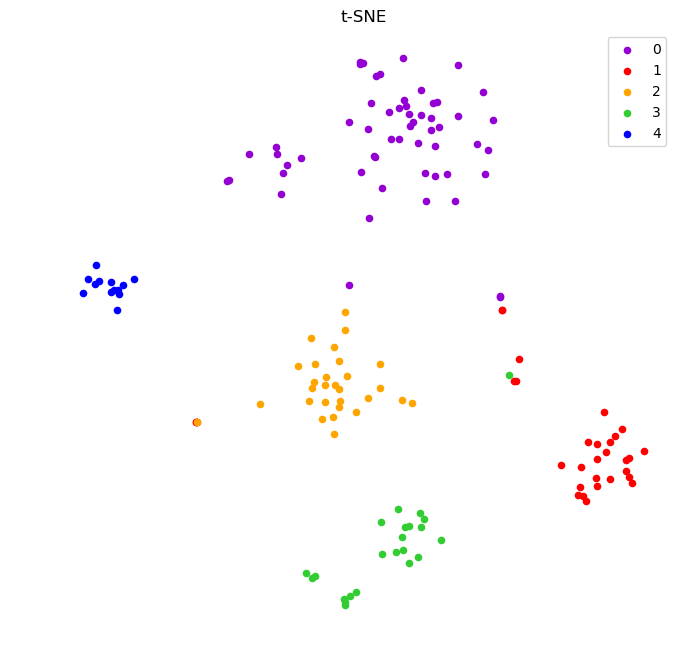

0
1
2
3
4
Time taken to perform Iteration 1 is: 810.3744487762451 secs
Time taken to perform all Iteration: 1 is: 13.506240812937419 mins
within processItern loop
ss is  []
num_f is  0
[]
assigned_percent  [0, 0]
Overall runtime is: 43.380513048172 mins


<Figure size 432x288 with 0 Axes>

In [278]:
##########################################
######### Iterations #####################
##########################################


def processItern(f):

    print('Fov is: ', str(f))
    asgn_stats = np.array([iter1,f,0,0]) # iter, fov, p, cellitwentto
    mRNA_asgn_counter = 0

    num_cells = cell_metadata_t_list[f].shape[0]

    '''nx31
    '''
    if(fig2p==1):
        fig2 = (f+1)*200+(f+1)
    #fig4 = (iter1+f+1)*4+(iter1+f+1)
    fig4 = (iter1+f+1)*4+f
    # cells are always the same per fov. so this is ok, no need to keep track of the iteration
    plt.figure(fig4,dpi=dpi_set,figsize=(12,12))
    plt.title(str(f))
    plt.axis('off')
    '''
    '''
    CoM_im_coords = CoM_image_coords_list[f] 

    '''
    for i in range(num_cells):
        feat_id = cell_metadata_t_list[f][i,1]
        feat_rows = np.where((mRNA_metadata_t[:,1]==f) & (mRNA_metadata_t[:,9]==feat_id) & (mRNA_metadata_t[:,10]==1)) #fov id, which cell and in/out of cell#feat_rows = np.where((mRNA_metadata_t[:, 1] == 0) & (mRNA_metadata_t[:, 9] == feat_id))
        feat_rows = np.array(feat_rows).flatten()
        num_rows = feat_rows.shape[0]
        for j in range(num_rows):
            x_stage_coord = mRNA_metadata_t[feat_rows[j],3]
            y_stage_coord = mRNA_metadata_t[feat_rows[j],4]
            a = np.array([[x_stage_coord, y_stage_coord]], dtype='float32')
            a = np.array([a])
            pointsOut = cv2.perspectiveTransform(a, h)
            x_image_coord = pointsOut[0,0,0]
            y_image_coord = pointsOut[0,0,1]
            plt.plot(x_image_coord, y_image_coord,'o',markersize=2, color=cm.colors[cluster_asgn[i]])
    '''

    #find l2-norm of each gene candidate to every cell
    #do just for image coordinates, it should be the same cells in the stage coords as wel
    l2_norm_mat =np.zeros([num_cells, len(mRNA_assign_list[f])],dtype=float)
    closest_cells = []

    mRNA_im_coords = mRNA_coords_list[f]  #added sandhya # all mRNA are always the same per fov. so this is ok, no need to keep track of the iteration

    #new mRNA assign list per fov #added sandhya
    to_rem_mRNA = asgn_stats_listoflists[iter1-1][f]
    len_rem_mRNA = len(to_rem_mRNA)
    print('len_rem_mRNA ',str(len_rem_mRNA))
    to_rem_mRNA_1=np.array([0])
    for l in range(len_rem_mRNA):
        pp = np.array(np.where(mRNA_all_list[f][to_rem_mRNA[l,2]]==mRNA_assign_list[f])).flatten()
        to_rem_mRNA_1 = np.concatenate((to_rem_mRNA_1,pp))

    to_rem_mRNA_1=np.delete(to_rem_mRNA_1,(0),axis=0)
    mRNA_assign_list[f]=np.delete(mRNA_assign_list[f],to_rem_mRNA_1,axis=0).copy() #added ,copy() 1st July 2020
    print('mRNA_assign_list[f] ', str(len(mRNA_assign_list[f]))) 
    
    # all mRNA to be assigned
    asgn_mRNA = np.intersect1d(mRNA_assign_list[f],mRNA_all_list[f])
    print('asgn_mRNA ',str(len(asgn_mRNA)))

    # per mRNA to be assigned, do:
    print("per mRNA to be assigned do: loop")
    for l in range(0,len(asgn_mRNA)): #//added 1st July 2020

        p = np.array(np.where(asgn_mRNA[l]==mRNA_all_list[f])).flatten()
        xc = mRNA_im_coords[p, 0]
        yc = mRNA_im_coords[p, 1]
        l_xc = xc - win_size
        r_xc = xc + win_size
        l_yc = yc - win_size
        u_yc = yc + win_size
        for i in range(num_cells):
            l2_norm_mat[i,l] = distance.euclidean([xc,yc], [CoM_im_coords[i,0],CoM_im_coords[i,1]])
        ##21st June 2020 check
        #print('distances 1')
        #print(l2_norm_mat[0:10,0:10])

        #23rd June 2020
        #closest_cells.append(np.argsort(l2_norm_mat[:,l])[0:neigh_size]) #this is the order of cells (ie cell id) but in Python. For real world, +1
        closest_cells.append(np.argsort(l2_norm_mat[:,l])[np.where((np.sort(l2_norm_mat[:,l])[0:neigh_size]<dist_ub)==True)]) 
        #1st quadrant
        #print("build the mock cell")
        
        # for a square
        # ind = [np.where((mRNA_im_coords[:,1] >= l_yc) & (mRNA_im_coords[:,1] <= u_yc) & (mRNA_im_coords[:,0] >= l_xc) & (mRNA_im_coords[:,0] <= r_xc))]
        
        # for a circle
        ind = np.where(pow(mRNA_im_coords[:,0]-xc,2) + pow(mRNA_im_coords[:,1]-yc,2) <= pow(win_size,2))
        ind = np.array(ind).flatten()
        num_mRNA_neighs = ind.shape[0]

        ##########mockcell weighted
        
        l2_norm_mat_1 =np.zeros([1, num_mRNA_neighs],dtype=float)
        for i in range(num_mRNA_neighs):
            l2_norm_mat_1[0,i] = distance.euclidean([xc,yc], [mRNA_im_coords[ind[i],0],mRNA_im_coords[ind[i],1]])

        
        mock_cell = np.zeros((1,num_genes))  #note change
        
        #####amme_narayan_weighted_mc - 9th sep 2020
        if (wgt_mock_cell):
            for k in range(num_mRNA_neighs):
                bc_id = mRNA_metadata_t[mRNA_all_list[f][ind[k]],0]-1 #telling which gene it is and where the entry should go to in the count matrix
                if(bc_id < num_genes):
                    mock_cell[0,int(bc_id)] = mock_cell[0,int(bc_id)]  +  1/l2_norm_mat_1[0,k] #amme_narayana 9th sep 2020

        
        else: #unweighted mock cell
            for k in range(num_mRNA_neighs):
                bc_id = mRNA_metadata_t[mRNA_all_list[f][ind[k]],0]-1 #telling which gene it is and where the entry should go to in the count matrix
                if(bc_id < num_genes):
                    mock_cell[0,int(bc_id)] = mock_cell[0,int(bc_id)]  +  1 #amme_narayana 9th sep 2020

        '''
        #mock_cell = np.zeros((1,num_genes))  
        #num_genes = 10
        mock_cell = np.zeros((1,num_genes))

        for k in range(num_mRNA_neighs):

            bc_id = mRNA_metadata_t[mRNA_all_list[f][ind[k]],0]-1 #telling which gene it is and where the entry should go to in the count matrix
            if(bc_id < num_genes):
                mock_cell[0,int(bc_id)] = mock_cell[0,int(bc_id)]  +  1

        '''
        ########
        

        # MLE with all K clusters
        #print("computing ML")
        mle_mockcell = np.zeros((1,len(unique)))

        #for u in range(len(unique)):
        for u in range(len(mean_mat)): 
            #mle_mockcell[0,u] = multivariate_normal.logpdf(zscore(mock_cell[0,0:10],axis=0), mean_mat[u], cov_list[u])
            mle_mockcell[0,u] = multivariate_normal.logpdf(zscore(mock_cell,axis=1), mean_mat[u][0:num_genes], cov_list[u])#print(mle_mockcell)

        mle_k = np.argmin(mle_mockcell)
        cc = np.array(closest_cells[l]).flatten()
        mle_cc = np.array(np.where(cluster_asgn[cc]==mle_k)).flatten()

        #plot this line from mRNA to assign to cell 
        if (len(mle_cc)!=0): #means there are cells in the neighbourhood of mRNA that are of the same class
            cell_to_map = cc[mle_cc[0]]
            #plt.figure(fig4,dpi=dpi_set,figsize=(12,12))
            if ((cell_to_map+cell_cumsum[f]) < M_upd.shape[0]): #added 20th June 2020
                '''nx31
                '''
                plt.plot(xc, yc,'x',markersize=2, c=cm[cluster_asgn[cell_to_map+cell_cumsum[f]]],alpha=0.5)

                x_temp = [CoM_im_coords[cell_to_map,0],xc]
                y_temp = [CoM_im_coords[cell_to_map,1],yc]
                '''
                '''
                mRNA_asgn_counter = mRNA_asgn_counter + 1

                ####nx31 
                plt.plot(x_temp, y_temp, linewidth=1, c=cm[cluster_asgn[cell_to_map+cell_cumsum[f]]])
                ###
                #Merfish_CM[cell_to_map+cell_cumsum[f], int(mRNA_metadata_t[mRNA_all_list[f][p],0]-1)] = Merfish_CM[cell_to_map+cell_cumsum[f], int(mRNA_metadata_t[mRNA_all_list[f][p],0]-1)] + 1
                Merfish_CM_list[f][cell_to_map, int(mRNA_metadata_t[mRNA_all_list[f][p],0]-1)] = Merfish_CM_list[f][cell_to_map, int(mRNA_metadata_t[mRNA_all_list[f][p],0]-1)] + 1


                a = np.array([iter1,f,p,cell_to_map]) #added sandhya
                asgn_stats = np.vstack((asgn_stats,a)) #added sandhya
    
        else:
            plt.figure(fig4)#,dpi=dpi_set,figsize=(12,12))
            plt.plot(xc,yc, '.', markersize=2, c='black')#, alpha=0.5)
        '''
        '''
    '''nx31
    '''
    plt.figure(fig4)#,dpi=dpi_set,figsize=(12,12))
    plt.title("Iter_"+str(iter1)+"_"+"Fov_"+str(f))
    plt.axis('off')
    file_name = os.path.join(path_python+'/figures_python/mRNA_assigned_seg_all_Iter='+str(iter1)+'_Fov='+str(f)+'.png')
    plt.savefig(file_name)
    '''
    '''
    asgn_stats = np.delete(asgn_stats, (0), axis=0)
    #asgn_stats_list.append(asgn_stats)
    #end of all fov
    return asgn_stats, mRNA_asgn_counter#, mRNA_assign_list # added mRNA_assign_list 1st July 2020
     

for iter1 in range(1,iterations):

        #mRNA_assign_listoflists = []#added on 2nd June 2020
        ##commneted the above on 4th July 2020
        print('Iteration is: ', str(iter1))
        #asgn_stats_list = []
        Merfish_CM = np.zeros((1,Merfish_genes)) #will have all the Count matrices consolidated
        for f in range(num_fov):
            Merfish_CM = np.concatenate((Merfish_CM,Merfish_CM_list[f]),axis=0) #20th june 2020


        Merfish_CM = np.delete(Merfish_CM, (0), axis=0)

        #remove rows that have 0 rowsum

        row_sums_CM = Merfish_CM.sum(axis=1,keepdims=True)
        rows_remove = np.where(row_sums_CM==0)
        Merfish_CM = np.delete(Merfish_CM,(rows_remove),axis=0)

        #added 20th June 2020
        cell_cumsum = np.cumsum(num_cells_list)
        cell_cumsum = np.hstack((0,cell_cumsum))

        for i in range(len(rows_remove[0])):
            print('i is', str(i))
            for j in range(i+1):
                print('j is', str(j))
                if ((j+1) < (len(cell_cumsum))):
                    if (rows_remove[0][i] < cell_cumsum[j+1]):
                        cell_cumsum[j+1] = cell_cumsum[j+1] - 1
                        print(cell_cumsum)
                continue
            continue

        #end add


        M_upd = zscore(Merfish_CM,axis=1)

        num_cells = M_upd.shape[0]
        num_genes = M_upd.shape[1]
        #save M_upd
        df_data = pd.DataFrame(M_upd)
        df_data.to_csv(os.path.join(path_python + '/count_data/count_matrix_Mupd_fovall_Iter_'+str(iter1)+'.csv'), header=None, index=None)

        #save count matrix 
        df_data = pd.DataFrame(Merfish_CM)
        df_data.to_csv(os.path.join(path_python + '/count_data/count_matrix_Merfish_fovall_Iter_'+str(iter1)+'.csv'), header=None, index=None)


        #perform clustering for the 'sure' pixels
        if(bayes_MM):
            Mod_dpgmm=BayesianGaussianMixture(n_components=num_comp, covariance_type='full',weight_concentration_prior_type='dirichlet_process').fit(M_upd)
            cluster_asgn = Mod_dpgmm.predict(M_upd)
        else:
            communities, graph, Q = pg.cluster(M_upd)#, k=num_comp, min_cluster_size=1)
            cluster_asgn = communities

        df_clusterlabel = pd.DataFrame(cluster_asgn)
        df_clusterlabel.to_csv(os.path.join(path_python + '/count_data/cluster_labels_postreasgn_Iter_'+str(iter1)+'.csv'), header=None,
                   index=None)

        X_2d = tsne.fit_transform(M_upd)
        df_data = pd.DataFrame(X_2d)
        df_data.to_csv(os.path.join(path_python + '/count_data/tSNE_embedding_post.csv'), header=None, index=None)

        unique, counts = np.unique(cluster_asgn, return_counts=True)
        #t-SNE plots
        target_ids = range(len(unique))
        plt.figure(figsize=(8,8),frameon=False,dpi=dpi_set)
        plt.axis('off')
        #colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
        for i,  label in zip(target_ids, unique):
            plt.scatter(X_2d[ cluster_asgn==(i), 0], X_2d[ cluster_asgn==(i), 1], color=cm[i], label=label,s=s_size)
        plt.legend()
        plt.title('t-SNE')
        plt.show()
        file_name = os.path.join(path_python+'/figures_python/tSNE_labels_postreasgn_newcoord_Iter_'+str(iter1)+'.png')
        plt.savefig(file_name,dpi=dpi_set)

        #mRNA_asgn_counter = np.zeros([num_fov,1])
        #####added 20th June 2020
        ##### recomputing the cluster moments based on the revised Merfish CMq
        #####
        mean_mat = [] #1 x genes per entry. K x genes overall
        cov_list = [] # genes x genes per entry. K genes x genes overall

        for i in range(len(unique)): #target_ids:
            print(i)
            #rows = np.where(cluster_asgn==unique[i])
            rows = np.where(cluster_asgn==unique[i])
            rows = np.array(rows).flatten()

            if (rows.shape[0] > 1):
                mean_mat.append(np.mean(M_upd[rows, :], axis=0))
                cov_mat = np.cov(M_upd[rows, 0:num_genes].T)
                cov_mat = np.dot(cov_mat,cov_mat.T)
                np.fill_diagonal(cov_mat, np.diag(cov_mat)+0.01)
                if (givens):
                    (Q, R) = givens_rotation(cov_mat)
                    cov_list.append(R)
                else:
                    cov_list.append(cov_mat)
                
        ##add end

        t3 = time.time()
        results = Parallel(n_jobs=num_cores)(delayed(processItern)(f) for f in inputs)
        t4 = time.time()
        print('Time taken to perform Iteration',str(iter1),'is:', str(t4-t3),'secs')
        print('Time taken to perform all Iteration:',str(iter1),'is:', str((t4-t3)/60),'mins')
        asgn_stats_list = [item[0] for item in results] #results#[item[0] for item in results]    
        assigned_percent = [item[1] for item in results] 
        
        
        ## added 2nd July 2020
        #mRNA_assign_listoflists = [item[2] for item in results]
        #mRNA_assign_listoflists.append(item[2] for item in results) ## added 4th July 2020
        #mRNA_assign_list = []        
        ## added end
        
        asgn_stats_listoflists.append(asgn_stats_list)
        ## added 20th June 2020

        ### sandhya added
        ### 17th Nov 2019
        #s=np.array(mRNA_asgn_counter_list).flatten()

        #11th Dec 2019 - sandhya added to remove ss just accessing FOV 0
        ss= np.array(np.where(np.array(assigned_percent).flatten()!=0)).flatten()
        #ss = np.array(np.where(assigned_percent!=0)).flatten() #new set of FOVs
        #s = s[ss]
        #mRNA_asgn_counter_list = s
        print('within processItern loop')
        print('ss is ',str(ss))
        num_f = len(ss)
        print('num_f is ',str(num_f))
        print(ss)

        #num_f = num_fov - 1
        #num_fov = len(ss)
        ##end add

        print("assigned_percent ",str(assigned_percent))
        '''
        if (not np.any(assigned_percent)):
            inputs=ss
            break
        if len(ss)!=0:
            for kk in range(0,num_fov):
                print('% of mRNA assigned over total dangling mRNAs in FOV ', str(ss[kk]),'is ', 
                  str(int(assigned_percent[ss[kk]])/len(mRNA_assign_list[ss[kk]])))
                print('% of mRNA assigned over total mRNAs in FOV ', str(ss[kk]),'is ', 
                  str(int(assigned_percent[ss[kk]])/len(mRNA_all_list[ss[kk]])))
        '''
inputs = ss
print('Overall runtime is:', str((t4-t1)/60),'mins')


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.10630917549133301 seconds
Jaccard graph constructed in 0.12518095970153809 seconds
Wrote graph to binary file in 0.01651787757873535 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.615971
Louvain completed 21 runs in 0.3457908630371094 seconds
PhenoGraph complete in 0.6044712066650391 seconds
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 152 samples in 0.000s...
[t-SNE] Computed neighbors for 152 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 152 / 152
[t-SNE] Mean sigma: 5.974906
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.182972
[t-SNE] KL divergence after 1000 iterations: 0.216730


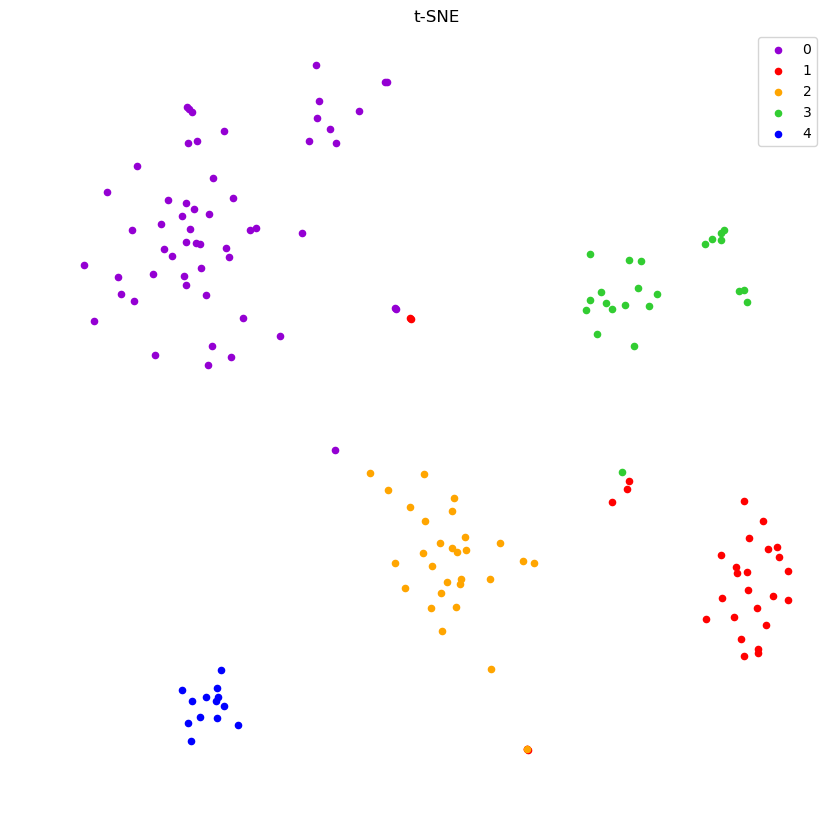

<Figure size 432x288 with 0 Axes>

In [279]:
#final Merfish_CM updated

Merfish_CM = np.zeros((1,Merfish_genes)) #will have all the Count matrices consolidated
for f in range(num_fov):
    Merfish_CM = np.concatenate((Merfish_CM,Merfish_CM_list[f]),axis=0) #20th june 2020


Merfish_CM = np.delete(Merfish_CM, (0), axis=0)

#remove rows that have 0 rowsum

row_sums_CM = Merfish_CM.sum(axis=1,keepdims=True)
rows_remove = np.where(row_sums_CM==0)
Merfish_CM = np.delete(Merfish_CM,(rows_remove),axis=0)

#added 20th June 2020
'''cell_cumsum = np.cumsum(num_cells_list)
cell_cumsum = np.hstack((0,cell_cumsum))

for i in range(len(rows_remove[0])):
    print('i is', str(i))
    for j in range(i+1):
        print('j is', str(j))
        if ((j+1) < (len(cell_cumsum))):
            if (rows_remove[0][i] < cell_cumsum[j+1]):
                cell_cumsum[j+1] = cell_cumsum[j+1] - 1
                print(cell_cumsum)
        continue
    continue

#end add
'''

M_upd = zscore(Merfish_CM,axis=1)

num_cells = M_upd.shape[0]
#num_genes = M_upd.shape[1]
num_genes = Merfish_genes #nx31
#save M_upd 
df_data = pd.DataFrame(M_upd)
df_data.to_csv(os.path.join(path_python + '/count_data/count_matrix_Mupd_fovall_Iter_'+str(iterations)+'.csv'), header=None, index=None)

#save count matrix 
df_data = pd.DataFrame(Merfish_CM)
df_data.to_csv(os.path.join(path_python + '/count_data/count_matrix_Merfish_fovall_Iter_'+str(iterations)+'.csv'), header=None, index=None)

#perform clustering for the 'sure' pixels
if(bayes_MM):
    Mod_dpgmm=BayesianGaussianMixture(n_components=num_comp, covariance_type='full',weight_concentration_prior_type='dirichlet_process').fit(M_upd)
    cluster_asgn = Mod_dpgmm.predict(M_upd)
else:
    communities, graph, Q = pg.cluster(M_upd)#, k=num_comp, min_cluster_size=1)
    cluster_asgn = communities

df_clusterlabel = pd.DataFrame(cluster_asgn)
df_clusterlabel.to_csv(os.path.join(path_python + '/count_data/cluster_labels_postreasgn_Iter_'+str(iterations)+'.csv'), header=None,
       index=None)

X_2d = tsne.fit_transform(M_upd)
df_data = pd.DataFrame(X_2d)
df_data.to_csv(os.path.join(path_python + '/count_data/tSNE_embedding_post_'+str(iterations)+'.csv'), header=None, index=None)

unique, counts = np.unique(cluster_asgn, return_counts=True)
#t-SNE plots
target_ids = range(len(unique))
plt.figure(figsize=(10,10),frameon=False,dpi=dpi_set)
plt.axis('off')
#colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i,  label in zip(target_ids, unique):
    plt.scatter(X_2d[ cluster_asgn==(i), 0], X_2d[ cluster_asgn==(i), 1], color=cm[i], label=label,s=s_size)
plt.legend()
plt.title('t-SNE')
plt.show()
file_name = os.path.join(path_python+'/figures_python/tSNE_labels_postreasgn_newcoord_Iter_'+str(iterations)+'.png')
plt.savefig(file_name,dpi=dpi_set)

In [280]:
###################################################################
## parallelise the overall merging of mRNA assignments per FOV ####
###################################################################




def processOverall(f):

    #asgn_stats = np.array([iter1,0,0,0]) #added sandhya

    if(fig2p==1):
        fig2 = (f+1)*200+(f+1)
    #fig4 = (iter1+f+1)*4+(iter1+f+1)
    fig4 = (iter1+f+1)*4+f

    #fig2 = (f+1)*200+(f+1)
    #fig4 = (f+1)*400+(f+1)

    plt.figure(fig4,dpi=dpi_set,figsize=(12,12))
    plt.title(str(f))
    plt.axis('off')

    print('Fov is: ', str(f))

    num_cells = cell_metadata_t_list[f].shape[0]


    #perspective projection
    if z==1:
        z_x = 6
        z_y = 7
    else:
        z_x = 6 + 2**(z-1)
        z_y = 7 + 2**(z-1)

    rw_x_boundary = cell_metadata_t_list[f][:,z_x]
    rw_y_boundary = cell_metadata_t_list[f][:,z_y]

    CoM_stage_coords = np.zeros([num_cells, 2], dtype=np.float)
    CoM_image_coords = np.zeros([num_cells, 2], dtype=np.float)

    #fig1 = (f+1)*100+(f+1)


    print('plotting cells')
    for i in range(num_cells): #i will be i+2th row in the xls

        #print("Cell= " + str(i))

        if(is_nan(rw_x_boundary[i]) | is_nan(rw_y_boundary[i])): #entries were empty: no segmentation found
            print("skip cell ", str(i))
        else:
            m = rw_x_boundary[i].split(';')
            n = rw_y_boundary[i].split(';')
            num_coord = m.__len__()

            # this can be done smarter. for now I cast every string float to float and place into a list
            m_list = []
            n_list = []
            for j in range(num_coord-1):
                if( (float(m[j])!=float(m[j]))  or (float(n[j])!=float(n[j]))):
                    print("Coord NaN is at = " + str(j))
                    #continue
                else:
                    m_list.append(float(m[j]))
                    n_list.append(float(n[j]))

            #to plot the stage coords
            #for k in np.arange(0, m_list.__len__()-1, 2):
                #print(k)
                #plt.figure(fig1,figsize=(10,10),dpi=dpi_set)
            #    connectpoints(m_list, n_list, k, k + 1)

            x_coord = np.array(m_list)  # (256,)
            y_coord = np.array(n_list)  # (256,)
            f1 = np.vstack((x_coord, y_coord))  # (2, 256)

            cX = sum(f1[0, :]) / f1.shape[1]
            cY = sum(f1[1, :]) / f1.shape[1]

            CoM_stage_coords[i, 0] = cX
            CoM_stage_coords[i, 1] = cY
            im_list = []
            in_list = []
            for s in range(m_list.__len__()):
                a = np.array([[f1[0, s], f1[1, s]]], dtype='float32')
                a = np.array([a])
                pointsOut = cv2.perspectiveTransform(a, h)
                im_list.append(pointsOut[0,0,0])
                in_list.append(pointsOut[0,0,1])

            for k in np.arange(0, im_list.__len__()-1, 2):

                plt.figure(fig4,figsize=(10,10),dpi=dpi_set)
                connectpoints(im_list, in_list, k, k + 1)

            ix_coord = np.array(im_list)  # (256,)
            iy_coord = np.array(in_list)  # (256,)
            f_image = np.vstack((ix_coord, iy_coord))  # (2, 256)

            cX_image = sum(f_image[0, :]) / f_image.shape[1]
            cY_image = sum(f_image[1, :]) / f_image.shape[1]

            CoM_image_coords[i,0] = cX_image
            CoM_image_coords[i,1] = cY_image


            if(fig2p==1):
                plt.figure(fig2) # sandhya ,dpi=dpi_set,figsize=(10,10))
                axes = plt.gca()
                #axes.add_patch(Polygon(np.transpose(f_image),closed=True, facecolor=colours[cluster_asgn[i]]))
                axes.add_patch(Polygon(np.transpose(f_image),closed=True, facecolor=cm.colors[cluster_asgn[i]]))


        ## plot mRNA inside the cell
        ##
        feat_id = cell_metadata_t_list[f][i,1]
        feat_rows = np.where((mRNA_metadata_t[:,1]==f) & (mRNA_metadata_t[:,9]==feat_id) & (mRNA_metadata_t[:,10]==1)) #fov id, which cell and in/out of cell
        #feat_rows = np.where((mRNA_metadata_t[:, 1] == 0) & (mRNA_metadata_t[:, 9] == feat_id))
        feat_rows = np.array(feat_rows).flatten()
        num_rows = feat_rows.shape[0]
        for j in range(num_rows):
            x_stage_coord = mRNA_metadata_t[feat_rows[j],3]
            y_stage_coord = mRNA_metadata_t[feat_rows[j],4]
            a = np.array([[x_stage_coord, y_stage_coord]], dtype='float32')
            a = np.array([a])

            #perspective proj
            pointsOut = cv2.perspectiveTransform(a, h)

            x_image_coord = pointsOut[0,0,0]
            y_image_coord = pointsOut[0,0,1]

            #plt.plot(x_image_coord, y_image_coord,'o',markersize=2, c=colours[cluster_asgn[i]],alpha=0.5)
            if ((i+cell_cumsum[f]) < M_upd.shape[0]):
                plt.plot(x_image_coord, y_image_coord,'.',markersize=4, color=cm[cluster_asgn[i+cell_cumsum[f]]])


    mRNA_im_coords = mRNA_coords_list[f]  #added sandhya # all mRNA are always the same per fov. so this is ok, no need to keep track of the iteration

    plt.figure(fig4,dpi=dpi_set,figsize=(12,12))
    for itert in range(iterations):
        print("within final mergen iteration is:", str(itert))
        if (f < len(asgn_stats_listoflists[itert])):
            to_plot_mRNA = asgn_stats_listoflists[itert][f]
            len_tp = len(to_plot_mRNA)
            #if (len_tp > 0):
            if (isinstance(to_plot_mRNA[0], np.ndarray)): 
                print('len_tp', len_tp)
                #nx31 print('to_plot_mRNA', to_plot_mRNA)

                for l in range(len_tp):

                    pp = to_plot_mRNA[l,2]
                    cell_pp = to_plot_mRNA[l,3]

                    if(pp < mRNA_im_coords.shape[0]):
                        xc = mRNA_im_coords[pp, 0]
                        yc = mRNA_im_coords[pp, 1]

                        if(cell_pp < CoM_image_coords.shape[0]):
                            if ((cell_pp+cell_cumsum[f]) < M_upd.shape[0]):
                                plt.plot(xc, yc,'x',markersize=2, c=cm[cluster_asgn[cell_pp+cell_cumsum[f]]],alpha=0.5)

                                x_temp = [CoM_image_coords[cell_pp,0],xc]
                                y_temp = [CoM_image_coords[cell_pp,1],yc]

                                plt.plot(x_temp, y_temp, linewidth=1, c=cm[cluster_asgn[cell_pp+cell_cumsum[f]]])


    plt.figure(fig4)
    plt.title("Final_plot_Fov_"+str(f))
    plt.axis('off')
    file_name = os.path.join(path_python+'/figures_python/overall_mRNA_assigned_seg_all_Fov='+str(f)+'.png')
    plt.savefig(file_name,dpi=dpi_set)


t5 = time.time()
inputs = range(num_fov)

results = Parallel(n_jobs=num_cores)(delayed(processOverall)(f) for f in inputs)
t6 = time.time()
print('Time taken to perform overall merge is',str(t6-t5),'secs')
print('Time taken to perform overall merge is',str((t6-t5)/60),'mins')


print('Overall runtime is:', str((t6-t1)/60),'mins')


Time taken to perform overall merge is 938.9033789634705 secs
Time taken to perform overall merge is 15.648389649391174 mins
Overall runtime is: 59.05610203345616 mins
